# SOM for SL PCA coefficients


- author : Sylvie Dagoret-Campagne
- affiliation  : IJCLab
- creation date : 2023/01/10


- https://github.com/JustGlowing/minisom
- https://github.com/JustGlowing/minisom/blob/master/examples/Clustering.ipynb
- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb
- https://github.com/JospehCeh/PhotoZ_PhD/tree/u/dagoret

https://heartbeat.comet.ml/introduction-to-self-organizing-maps-soms-98e88b568f5d

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from sklearn_som.som import SOM
from minisom import MiniSom

In [3]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))
import copy

In [4]:
from astropy.io import fits

## Read input file

In [5]:
all_filenames = ['datatools/pcamethod1_SL_eigenvectorandcoeff.fits']

# choose the SED
infile_idx=0
filename = all_filenames[infile_idx]
hdu = fits.open(filename)
hdu.info()

Filename: datatools/pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


### Read Spectra

In [6]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

### Read PCA coefficients

In [7]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

### Read PCA eigenvectors

In [8]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

## Decode data

### Decode spectra data

In [9]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 


### Decode PCA data

In [10]:
X = copy.deepcopy(data2[:,:])

# Normalize the data

In [11]:
X = (spec - np.mean(spec, axis=0)) / np.std(spec, axis=0)

# SOM



    algorithm to train the map : https://eric.univ-lyon2.fr/~ricco/cours/slides/en/kohonen_som.pdf

Input: dataset, size and topology of the map

Output: the codebook for each output node

        Randomize the map’s nodes weight
        Select randomly one instance
        Find the closest node: best matching unit
        The codebook of this node is updated
        The codebooks of the adjacent nodes are also updated, by not to the same degree
        Reduce the intensity of the update progressively
        Repeat 1 to 6 for Tmax iterations

Weight update rule for a node
, knowing that

is the winning node:

: learning rate

: neighbourhood function
where

is the euclidian distance between node i and j on Kohonen (flat-2D ) map

and

    are hyperparameters



- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb

In [12]:
# Initialization and training

n_neurons = 60
m_neurons = 60

learning_rate_0=0.5
sigma_0= 7
Niter = 1000

#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=1.5, learning_rate=.1, neighborhood_function='gaussian', random_seed=0)
#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5, neighborhood_function='gaussian', random_seed=0)
som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=sigma_0, learning_rate=learning_rate_0, neighborhood_function='gaussian', random_seed=0)
              
    
som.pca_weights_init(X)
som.train(X, Niter, verbose=True)  # random training

/Users/dagoret/anaconda3/lib/python3.9/site-packages/minisom.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 1000 / 1000 ] 100% - 0:00:01 left 
 quantization error: 6.971535570125012


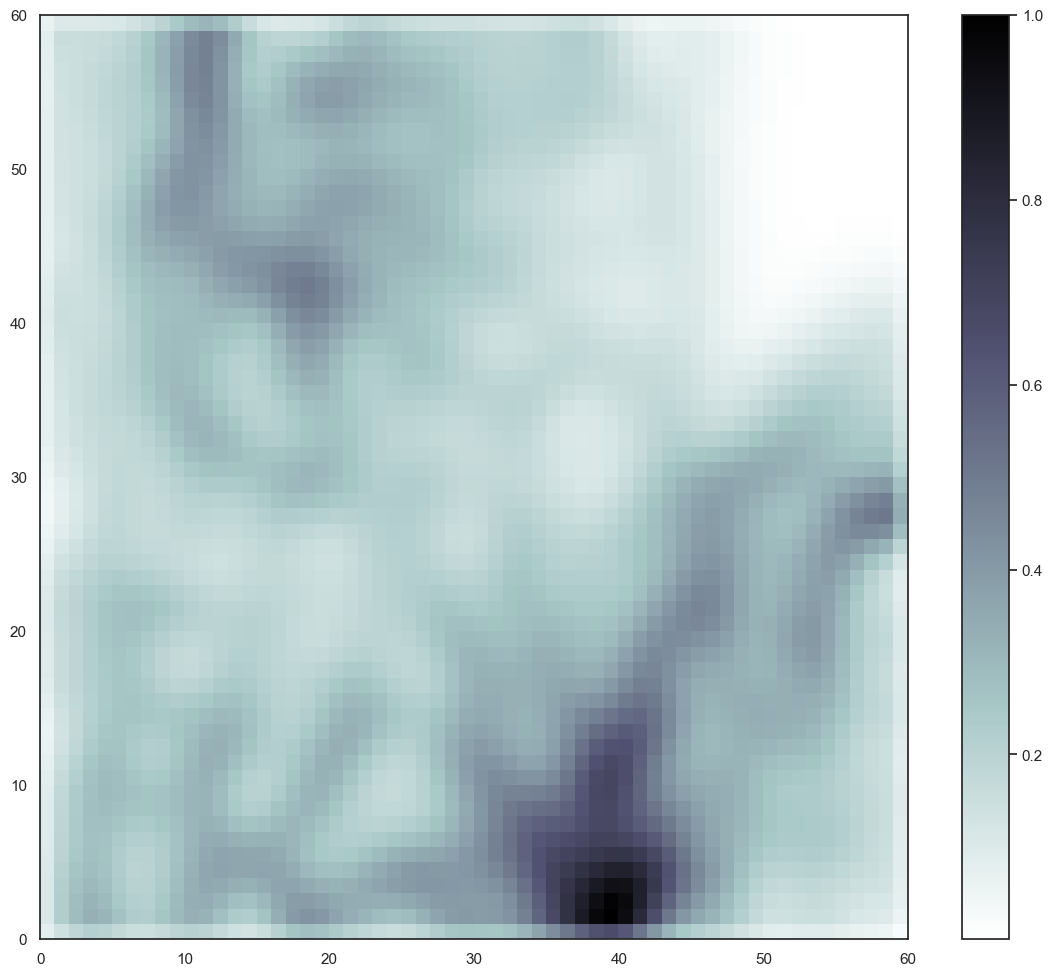

In [13]:
plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

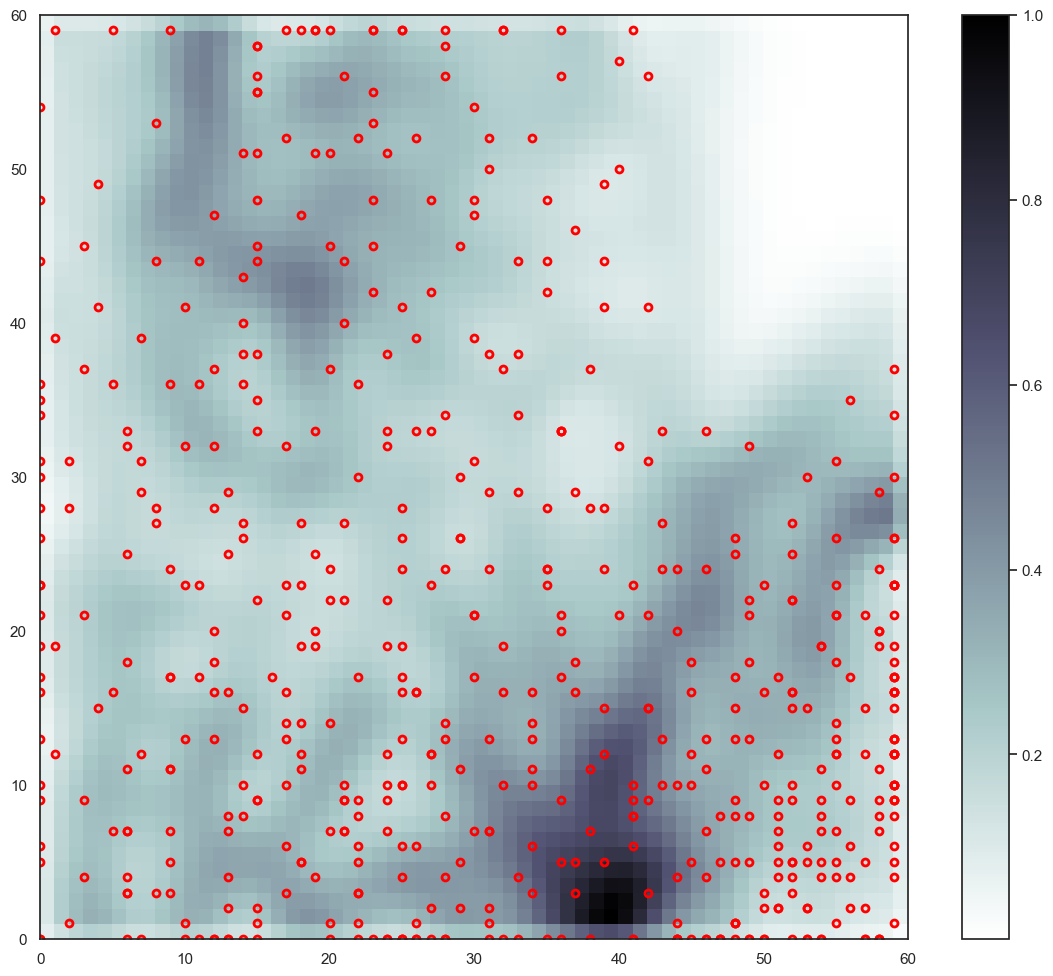

In [14]:
plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label



for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0], w[1], 'o', markerfacecolor='None',markeredgecolor='r', markersize=5, markeredgewidth=2)

plt.show()



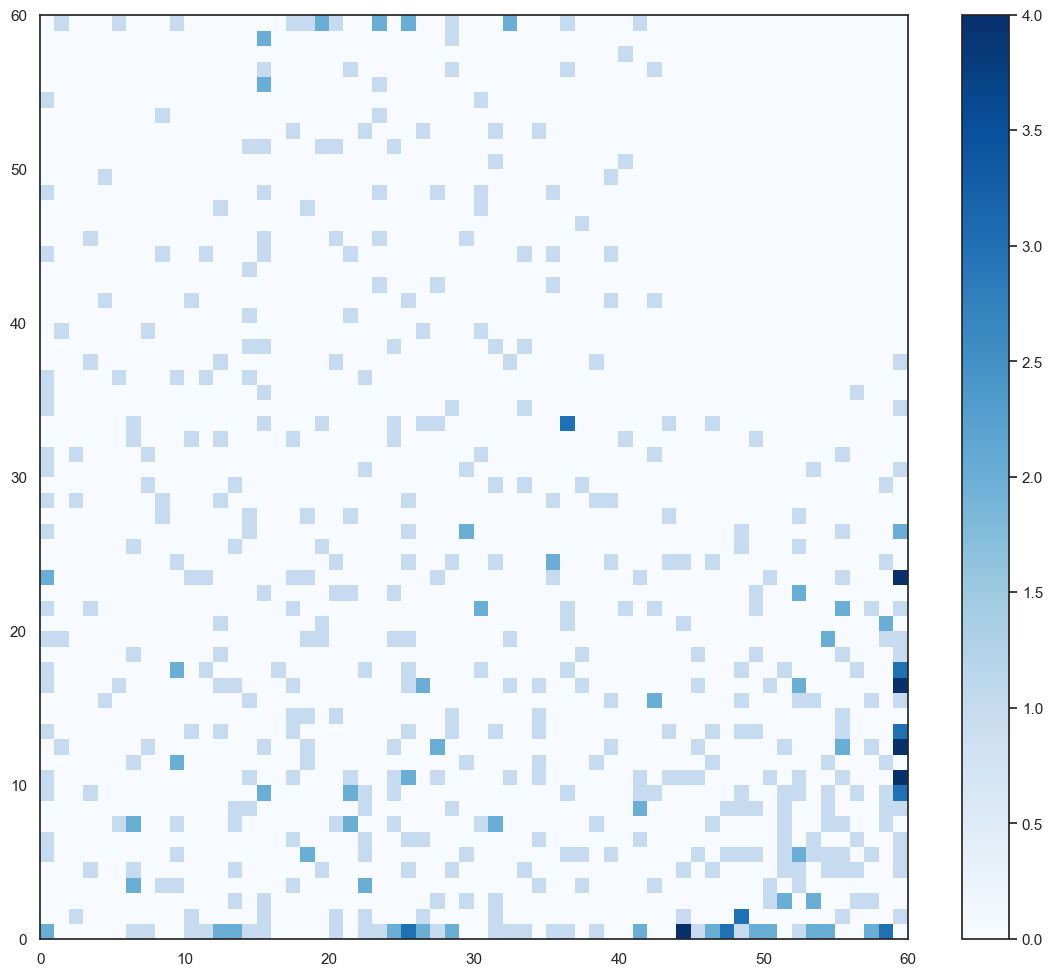

In [15]:
plt.figure(figsize=(14, 12))
frequencies = som.activation_response(X)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()


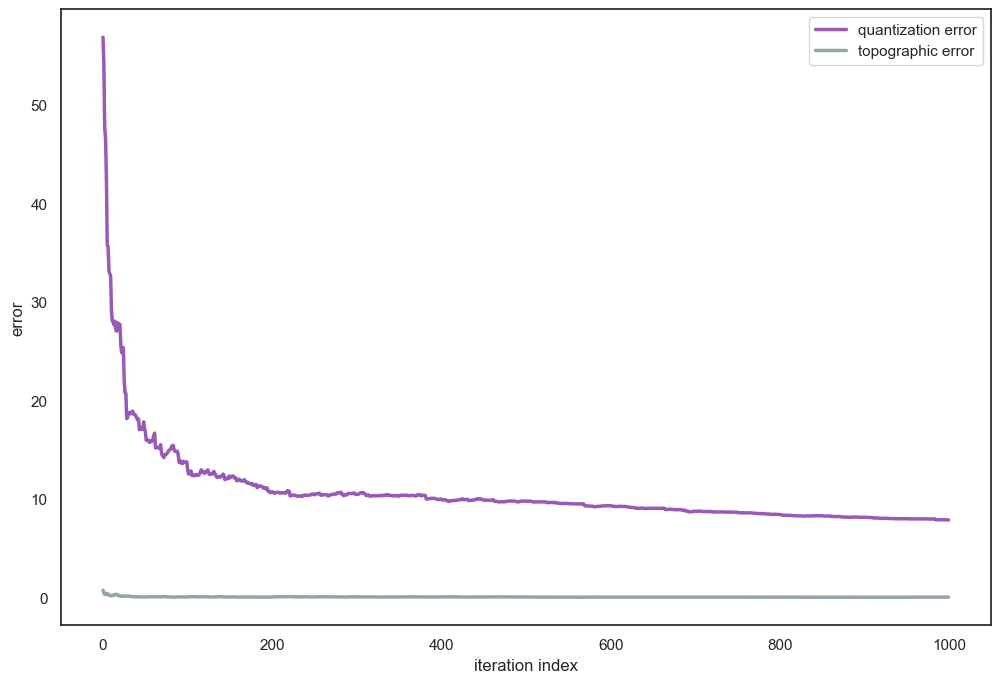

In [16]:
som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(X))
    som.update(X[rand_i], som.winner(X[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(X))
    t_error.append(som.topographic_error(X))

plt.figure(figsize=(12,8))
plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()
